# TrainLB

In [1]:
using AutomotiveDrivingModels
using DynamicBayesianNetworkBehaviors

## Parameters

In [2]:
include(Pkg.dir("AutomotiveDrivingModels", "scripts", "extract_params.jl"))
dset_filepath_modifier = "_following" # _freeflow, _following, _lanechange
dset = JLD.load(joinpath(EVALUATION_DIR, "dataset2" * dset_filepath_modifier * ".jld"),
                "model_training_data")::ModelTrainingData2
runlogs_original = load_runlogs(dset)
streetnets = load_streetnets(runlogs_original)

fold = 1
cv_split_outer = get_fold_assignment_across_drives(dset, N_FOLDS)
cv_split_inner = drop_fold!(deepcopy(cv_split_outer), fold)
@assert(cv_split_inner.nfolds > 0)

ntraces = length(cv_split_outer.seg_assignment);

## Optimize Hyperparams

In [3]:
train_def = BehaviorTrainDefinition(
                                    LB_TrainParams(
                                        indicators=INDICATOR_SET2,
                                        max_parents=10,
                                        verbosity=0,
                                    ),
                                    BehaviorParameter[
                                    ])

preallocated_data = preallocate_learning_data(dset, train_def.trainparams)
print(train_def); sleep(0.1)

BehaviorTrainDefinition
LB Train Params
	targets: (:f_des_angle,:f_accel)
	indicators: [:posFyaw,:posFt,:speed,:velBx,:velBy,:velFs,:velFt,:turnrate,:acc,:accFs,:accFt,:accBx,:accBy,:d_ml,:d_mr,:ttcr_ml,:ttcr_mr,:est_ttcr,:a_req_stayinlane,:n_lane_left,:n_lane_right,:has_lane_right,:has_lane_left,:curvature,:dist_merge,:dist_split,:scene_speed_diff,:has_front,:d_front,:d_y_front,:dv_x_front,:dv_y_front,:yaw_front,:turnrate_front,:acc_req_front,:inv_ttc_front,:inv_timegap_front,:gaining_on_front,:has_rear,:d_rear,:d_y_rear,:dv_x_rear,:dv_y_rear,:yaw_rear,:turnrate_rear,:acc_req_rear,:inv_ttc_rear,:inv_timegap_rear,:gaining_on_rear,:has_left,:d_left,:d_y_left,:dv_x_left,:dv_y_left,:yaw_left,:turnrate_left,:acc_req_left,:inv_ttc_left,:inv_timegap_left,:left_is_gaining,:has_right,:d_right,:d_y_right,:dv_x_right,:dv_y_right,:yaw_right,:turnrate_right,:acc_req_right,:inv_ttc_right,:inv_timegap_right,:right_is_gaining,:past_1_velFt,:past_2_velFt,:past_3_velFt,:past_4_velFt,:past_1_posFt,:past

In [4]:
preallocated_data.features_disc

12-element Array{AutomotiveDrivingModels.Features.AbstractFeature,1}:
 AutomotiveDrivingModels.Features.Feature_N_Lane_Left()     
 AutomotiveDrivingModels.Features.Feature_N_Lane_Right()    
 AutomotiveDrivingModels.Features.Feature_Has_Lane_Right()  
 AutomotiveDrivingModels.Features.Feature_Has_Lane_Left()   
 AutomotiveDrivingModels.Features.Feature_Has_Front()       
 AutomotiveDrivingModels.Features.Feature_Gaining_On_Front()
 AutomotiveDrivingModels.Features.Feature_Has_Rear()        
 AutomotiveDrivingModels.Features.Feature_Rear_Is_Gaining() 
 AutomotiveDrivingModels.Features.Feature_Has_Left()        
 AutomotiveDrivingModels.Features.Feature_Left_Is_Gaining() 
 AutomotiveDrivingModels.Features.Feature_Has_Right()       
 AutomotiveDrivingModels.Features.Feature_Right_Is_Gaining()

In [5]:
preallocated_data.features_cont

19-element Array{AutomotiveDrivingModels.Features.AbstractFeature,1}:
 AutomotiveDrivingModels.Features.Feature_PosFyaw()               
 AutomotiveDrivingModels.Features.Feature_PosFt()                 
 AutomotiveDrivingModels.Features.Feature_Speed()                 
 AutomotiveDrivingModels.Features.Feature_VelBx()                 
 AutomotiveDrivingModels.Features.Feature_VelBy()                 
 AutomotiveDrivingModels.Features.Feature_VelFs()                 
 AutomotiveDrivingModels.Features.Feature_VelFt()                 
 AutomotiveDrivingModels.Features.Feature_TurnRate()              
 AutomotiveDrivingModels.Features.Feature_Acc()                   
 AutomotiveDrivingModels.Features.Feature_AccFs()                 
 AutomotiveDrivingModels.Features.Feature_AccFt()                 
 AutomotiveDrivingModels.Features.Feature_AccBx()                 
 AutomotiveDrivingModels.Features.Feature_AccBy()                 
 AutomotiveDrivingModels.Features.Feature_MarkerDist_Left()

In [6]:
preallocated_data.features_nann

76-element Array{AutomotiveDrivingModels.Features.AbstractFeature,1}:
 AutomotiveDrivingModels.Features.Feature_TimeToCrossing_Left()             
 AutomotiveDrivingModels.Features.Feature_TimeToCrossing_Right()            
 AutomotiveDrivingModels.Features.Feature_EstimatedTimeToLaneCrossing()     
 AutomotiveDrivingModels.Features.Feature_A_REQ_StayInLane()                
 AutomotiveDrivingModels.Features.Feature_Dist_Front()                      
 AutomotiveDrivingModels.Features.Feature_D_Y_Front()                       
 AutomotiveDrivingModels.Features.Feature_Delta_V_Front()                   
 AutomotiveDrivingModels.Features.Feature_Delta_V_Y_Front()                 
 AutomotiveDrivingModels.Features.Feature_Yaw_Front()                       
 AutomotiveDrivingModels.Features.Feature_Turnrate_Front()                  
 AutomotiveDrivingModels.Features.Feature_Acc_Req_Front()                   
 AutomotiveDrivingModels.Features.Feature_Inv_TTC_Front()                   
 Autom

In [7]:
# AutomotiveDrivingModels.optimize_hyperparams_cyclic_coordinate_ascent!(
#                     train_def, dset, preallocated_data, cv_split_inner)
# print(train_def); sleep(0.1)

## Train

In [8]:
LB = train(dset, preallocated_data, train_def.trainparams, FoldSet(cv_split_outer, fold, false, :frame))
println("\n\n")
print(LB)
sleep(0.5)




Linear Gaussian Bayesian Network Behavior
	targets: (:f_des_angle,:f_accel)
	features: 
		discrete:   [:has_lane_left,:gaining_on_front,:has_rear,:has_left,:right_is_gaining]
		continuous: [:acc,:accFt,:accBx,:est_ttcr,:past_1_acc,:past_1_f_des_angle,:mean_8_acc,:mean_8_f_des_angle,:max_4_acc,:f_des_angle,:f_accel]
	number of suffstats for lat: 576
	number of suffstats for lon: 352
	parents lat: [:gaining_on_front,:has_rear,:has_left,:right_is_gaining]
	             [:accFt]
	             [:est_ttcr,:past_1_f_des_angle,:mean_8_f_des_angle]
	parents lon: [:has_lane_left,:gaining_on_front,:has_rear]
	             [:acc,:accBx]
	             [:past_1_acc,:mean_8_acc,:max_4_acc]
	sample lat first: true


## Likelihood

In [9]:
arr_logl_train = Float64[]
arr_logl_test = Float64[]
for frameind in 1 : nrow(dset.dataframe)
    logl = calc_action_loglikelihood(LB, dset.dataframe, frameind)
    
    if check_fold_match(fold, cv_split_outer.frame_assignment[frameind], true)
        push!(arr_logl_test, logl)
    else
        push!(arr_logl_train, logl)
    end
end

@printf("%20s  %12s  %12s  %12s\n", "min", "mean", "median", "max")
@printf("%20.4f  %12.4f  %12.4f  %12.4f\n", minimum(arr_logl_train), mean(arr_logl_train), median(arr_logl_train), maximum(arr_logl_train))
@printf("%20.4f  %12.4f  %12.4f  %12.4f\n", minimum(arr_logl_test), mean(arr_logl_test), median(arr_logl_test), maximum(arr_logl_test))

                 min          mean        median           max
  

## Simulations

  likely near /home/tim/.julia/v0.4/Reel/src/Reel.jl:14
  likely near /home/tim/.julia/v0.4/Reel/src/Reel.jl:14


   -179888943.3850   -43894.1873       11.4576       13.1950
         -23698.9630        4.2045       11.1553       13.1950


 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at loading.jl:243
 [inlined code] from /home/tim/.julia/v0.4/Requires/src/require.jl:11
 in require at /home/tim/.julia/v0.4/Requires/src/hook.jl:17
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/tim/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/tim/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading /home/tim/.julia/v0.4/Reel/src/Reel.jl, in expression starting on line 14


Interact.Slider{Int64}(Signal{Int64}(1160, nactions=0),"frame",1160,1100:1220,true)

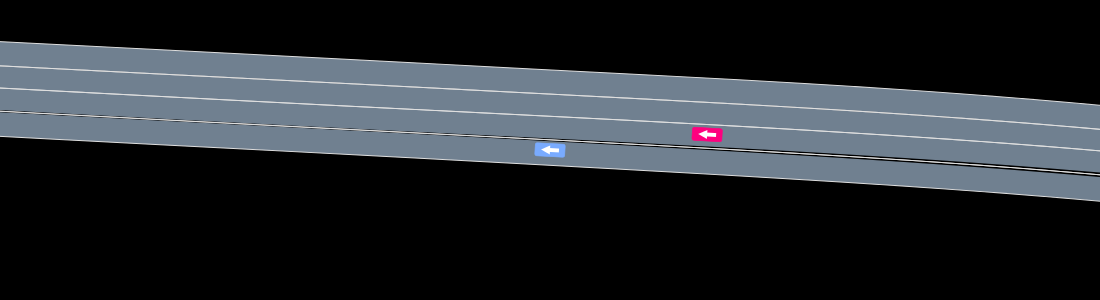

 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at loading.jl:243
 [inlined code] from /home/tim/.julia/v0.4/Requires/src/require.jl:11
 in require at /home/tim/.julia/v0.4/Requires/src/hook.jl:17
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/tim/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/tim/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading /home/tim/.julia/v0.4/Reel/src/Reel.jl, in expression starting on line 85
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at loading.jl:243
 [inlined code] from /home/tim/.julia/v0.4/Requires/src/require.jl:11
 in require at /home/tim/.julia/v0.4/Requires/src/hook.jl:17
 in include at ./boot.jl:261
 in

In [10]:
include(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_cairo_utils.jl"))

runlogseg = dset.runlog_segments[101]
runlog = runlogs_original[runlogseg.runlog_id]
sn = streetnets[runlog.header.map_name]

seg_duration = runlogseg.frame_end - runlogseg.frame_start
where_to_start_copying_from_original_runlog = max(1, runlogseg.frame_start - DEFAULT_TRACE_HISTORY)
where_to_start_simulating_from_runlog_sim = runlogseg.frame_start - where_to_start_copying_from_original_runlog + 1
where_to_end_simulating_from_runlog_sim = where_to_start_simulating_from_runlog_sim + seg_duration

runlog_sim = deepcopy(runlog, where_to_start_copying_from_original_runlog, runlogseg.frame_end)
plot_manipulable_runlog(runlog, sn, frames=where_to_start_copying_from_original_runlog:runlogseg.frame_end, overlays=Overlay[])
# roll(
#     reel_runlog(runlog, sn, runlogseg.carid, frames=where_to_start_copying_from_original_runlog:runlogseg.frame_end),
#     fps=40)

In [11]:
simulate!(runlog_sim, sn, LB, runlogseg.carid, 
          where_to_start_simulating_from_runlog_sim, where_to_end_simulating_from_runlog_sim);

Interact.Slider{Int64}(Signal{Int64}(61, nactions=0),"frame",61,1:121,true)

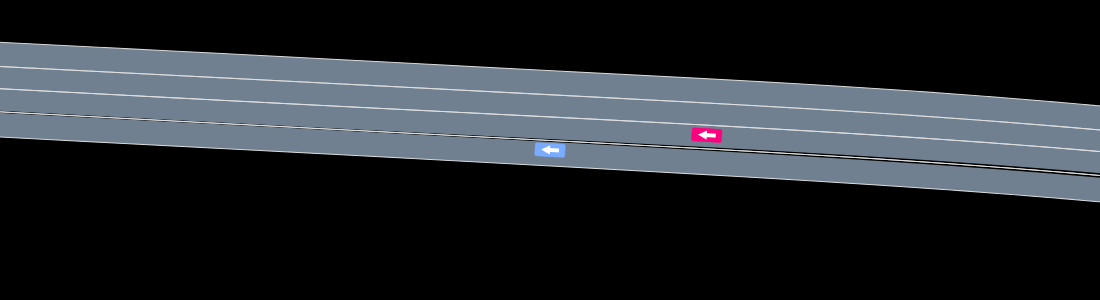

In [12]:
include(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_dbn_cairo_utils.jl"))
plot_manipulable_runlog(runlog_sim, sn, overlays=Overlay[])
# roll(reel_runlog(runlog_sim, sn, runlogseg.carid, overlays=Overlay[BNCountsOverlay(BN)]), fps=40)

    .>(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:179
is ambiguous with: 
    .>(AbstractArray{Bool, N<:Any}, Union{DataArrays.DataArray{Bool, N<:Any}, DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}}) at /home/tim/.julia/v0.4/DataArrays/src/broadcast.jl:330.
To fix, define 
    .>(Images.AbstractImageDirect{Bool, N<:Any}, Union{DataArrays.DataArray{Bool, N<:Any}, DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}})
before the new definition.
    .>(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:179
is ambiguous with: 
    .>(AbstractArray, Union{DataArrays.DataArray, DataArrays.PooledDataArray}) at /home/tim/.julia/v0.4/DataArrays/src/broadcast.jl:285.
To fix, define 
    .>(Images.AbstractImageDirect, Union{DataArrays.DataArray, DataArrays.PooledDataArray})
before the new definition.
    .*(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:

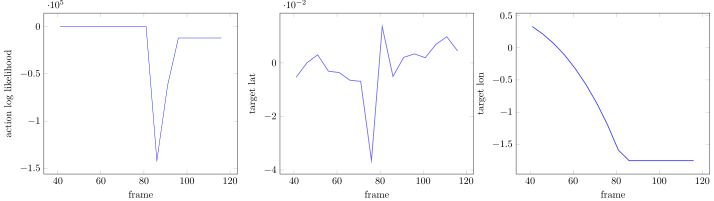

In [13]:
# simulated trajectory
include(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_pgfplots_utils.jl"))
# plot_group_logl_vs_trace(LB, runlog_sim, sn, 40, nframes(runlog_sim)-5, ID_EGO)
# plot_group_logl_vs_trace(LB, runlog_sim, sn, 40+1, nframes(runlog_sim)-5, ID_EGO)
plot_group_logl_vs_trace(LB, runlog_sim, sn, where_to_start_simulating_from_runlog_sim, where_to_end_simulating_from_runlog_sim, ID_EGO)

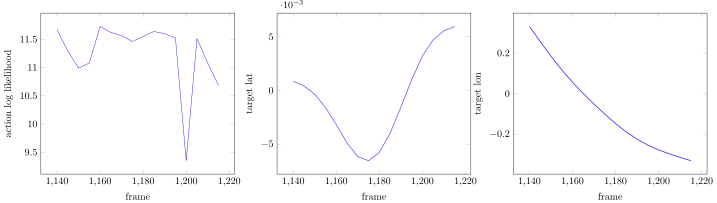

In [14]:
# original trajectory
plot_group_logl_vs_trace(LB, runlog, sn, runlogseg.frame_start, runlogseg.frame_start+seg_duration-5, ID_EGO)

Interact.Slider{Int64}(Signal{Int64}(1160, nactions=0),"frame",1160,1100:1220,true)

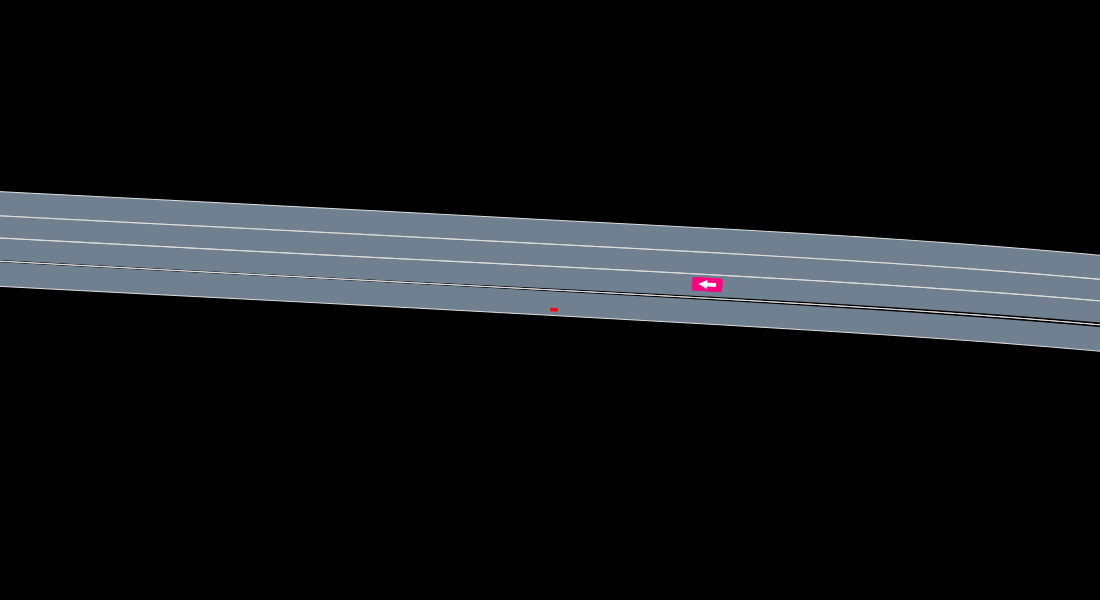

In [15]:
include(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_cairo_utils.jl"))
generate_and_plot_manipulable_gridcount_set(LB, runlog, sn, runlogseg)

Interact.Slider{Int64}(Signal{Int64}(1160, nactions=0),"frame",1160,1100:1220,true)

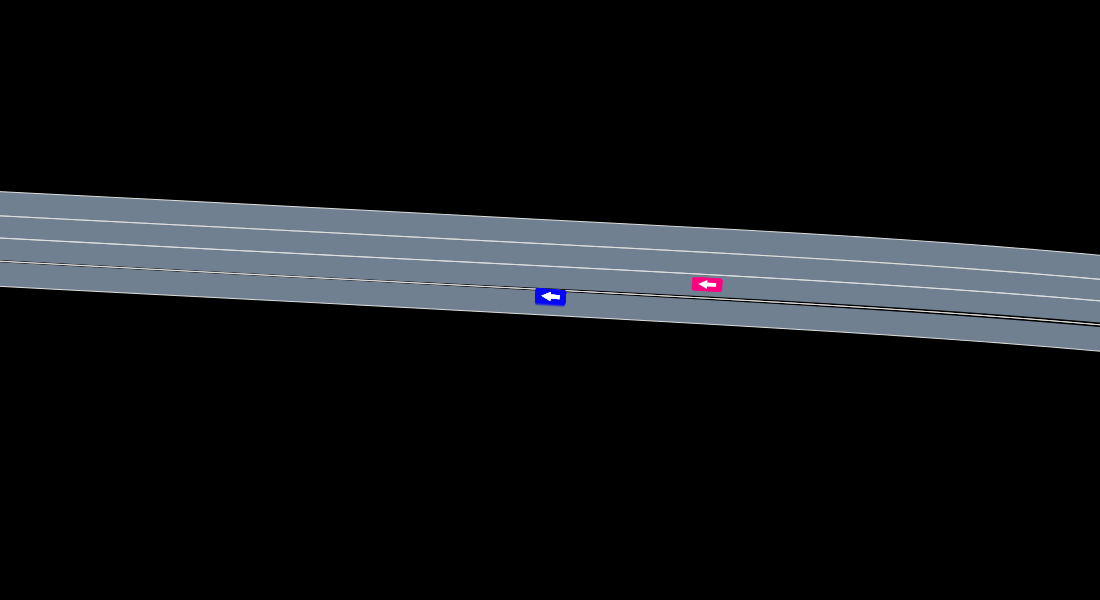

In [16]:
include(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_cairo_utils.jl"))
generate_and_plot_manipulable_future_pos_set(LB, runlog, sn, runlogseg)

Interact.Slider{Int64}(Signal{Int64}(1160, nactions=0),"frame",1160,1100:1220,true)

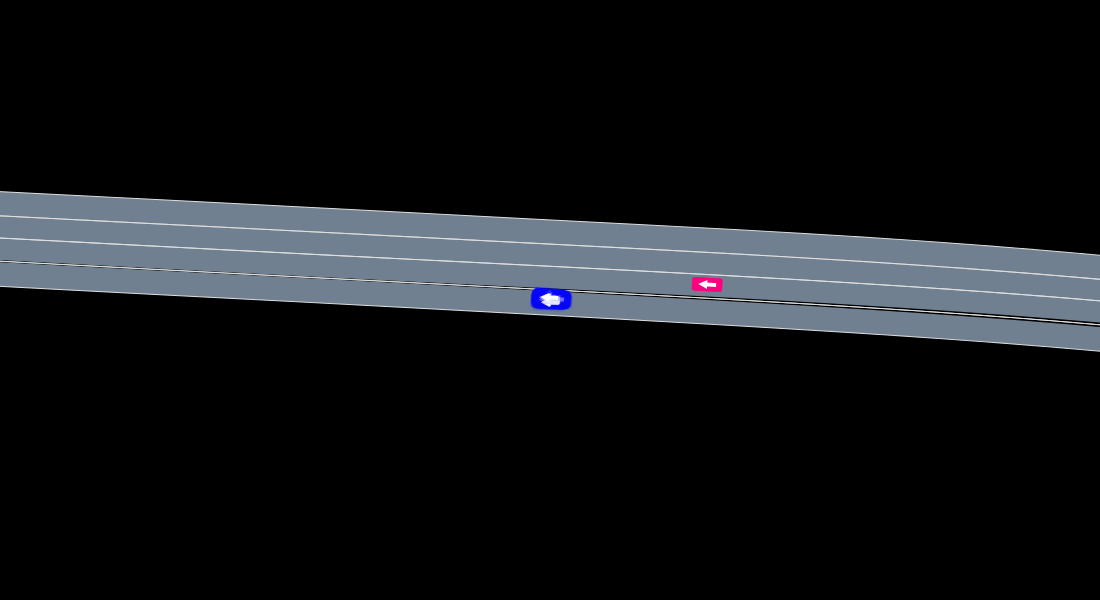

In [17]:
include(Pkg.dir("AutomotiveDrivingModels", "viz", "incl_cairo_utils.jl"))
SG = VehicleBehaviorGaussian(0.001,1.0)
generate_and_plot_manipulable_future_pos_set(SG, runlog, sn, runlogseg)